In [1]:
import os 
import time  
import pandas as pd  
import numpy as np  
import joblib 
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    KFold,
) 
from sklearn.preprocessing import StandardScaler  # Feature scaling
from sklearn.linear_model import ElasticNet  # ElasticNet regression
from sklearn.ensemble import RandomForestRegressor  # Random Forest model
from sklearn.tree import DecisionTreeRegressor  # Decision Tree model
from sklearn.pipeline import Pipeline  # Creating ML pipelines
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
)  
import category_encoders as ce  # Encoding categorical variables
from xgboost import XGBRegressor  # XGBoost model

# Set global float display format
pd.options.display.float_format = "{:,.0f}".format

In [2]:
df = pd.read_csv("../data/raw/data_set.csv")
df.drop(columns="Price(USD)",inplace=True)
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,63,1,True,True,True,Shahran,"1,850,000,000"
1,60,1,True,True,True,Shahran,"1,850,000,000"
2,79,2,True,True,True,Pardis,"550,000,000"
3,95,2,True,True,True,Shahrake Qods,"902,500,000"
4,123,2,True,True,True,Shahrake Gharb,"7,000,000,000"


In [3]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area       3479 non-null   object 
 1   Room       3479 non-null   int64  
 2   Parking    3479 non-null   bool   
 3   Warehouse  3479 non-null   bool   
 4   Elevator   3479 non-null   bool   
 5   Address    3456 non-null   object 
 6   Price      3479 non-null   float64
dtypes: bool(3), float64(1), int64(1), object(2)
memory usage: 441.8 KB


# Preprosseing

### Area Column

In [4]:
df["Area"] = df["Area"].str.replace(",","").astype(int)

### Boolean Column

In [5]:
bool_col = df.select_dtypes(include="bool").columns
for i in bool_col:
    df[i]=df[i].astype("int8")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area       3479 non-null   int64  
 1   Room       3479 non-null   int64  
 2   Parking    3479 non-null   int8   
 3   Warehouse  3479 non-null   int8   
 4   Elevator   3479 non-null   int8   
 5   Address    3456 non-null   object 
 6   Price      3479 non-null   float64
dtypes: float64(1), int64(2), int8(3), object(1)
memory usage: 119.0+ KB


### Remove Missing value

In [7]:
df.isnull().any()

Area         False
Room         False
Parking      False
Warehouse    False
Elevator     False
Address       True
Price        False
dtype: bool

In [8]:
df.isnull().sum()

Area          0
Room          0
Parking       0
Warehouse     0
Elevator      0
Address      23
Price         0
dtype: int64

In [9]:
df.dropna(inplace=True)

In [10]:
df.isnull().any()

Area         False
Room         False
Parking      False
Warehouse    False
Elevator     False
Address      False
Price        False
dtype: bool

In [11]:
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,63,1,1,1,1,Shahran,"1,850,000,000"
1,60,1,1,1,1,Shahran,"1,850,000,000"
2,79,2,1,1,1,Pardis,"550,000,000"
3,95,2,1,1,1,Shahrake Qods,"902,500,000"
4,123,2,1,1,1,Shahrake Gharb,"7,000,000,000"


In [12]:
for i in df.iloc[:,:5].columns:
    print(f"column name {i}:\n{df[i].unique()}")

column name Area:
[         63          60          79          95         123          70
          87          59          54          71          68          64
         136         155         140          42          93          65
          99         105         160          77         110         100
          90          49          96          67          62          55
         129         109          58         150         130          88
          51         113          98          75          61          72
         122         215         101          53          74         114
         151         300          76         148          40         128
          94          97         137          85          78          48
          82         120         139          66          80          44
          50         121         141         127         180         158
         144         245         190         108         117         200
         125         236         

### Remove Outlier

In [13]:
def remove_out_liers (df , columns = ["Area","Price"]):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]

    return df



In [14]:
df.shape

(3456, 7)

In [15]:
clean_data=remove_out_liers(df)
clean_data.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,63,1,1,1,1,Shahran,"1,850,000,000"
1,60,1,1,1,1,Shahran,"1,850,000,000"
2,79,2,1,1,1,Pardis,"550,000,000"
3,95,2,1,1,1,Shahrake Qods,"902,500,000"
4,123,2,1,1,1,Shahrake Gharb,"7,000,000,000"


In [16]:
clean_data.shape

(3000, 7)

In [17]:
for i in clean_data.iloc[:,:5].columns:
    print(f"column name {i}:\n{clean_data[i].unique()}")

column name Area:
[ 63  60  79  95 123  70  87  59  54  71  68  64 155 140  42  93  65  99
 105  77 110 100  90  49  96  67  62  55 129 109  58 150 130  88  51 113
  98  75  61  72 122 101  53  74 114 151  76 148  40 128  94  97 137  85
  78 136  48  82 120 139  66  80  44  50 121 160 141 127 180 158 144 108
 117 125  86  84 106 124  83 104 103 135 132  81 115 118 116  43  91 126
 145 112 164 170  92 165 143 167  69  57 102 133  73 134  89 111 147 173
 162 156  45 161  46 107 175 131 185 171 138  38  56  52 146 142 179 157
 176 149  37  41 154  47 198 119 152 153 174  39 172  35  32 163  33 190
  30 186]
column name Room:
[1 2 3 0 4 5]
column name Parking:
[1 0]
column name Warehouse:
[1 0]
column name Elevator:
[1 0]


In [19]:
clean_data.describe()

,Area,Room,Parking,Warehouse,Elevator,Price
count,"3,000","3,000","3,000","3,000","3,000","3,000"
mean,89,2,1,1,1,"3,152,024,000"
std,30,1,0,0,0,"2,486,862,294"
min,30,0,0,0,0,"3,600,000"
25%,66,2,1,1,1,"1,205,500,000"
50%,85,2,1,1,1,"2,380,000,000"
75%,105,2,1,1,1,"4,250,000,000"
max,198,5,1,1,1,"10,800,000,000"


In [20]:
clean_data.columns

Index(['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address', 'Price'], dtype='object')

In [21]:
import matplotlib.pyplot as plt 
import seaborn as sns

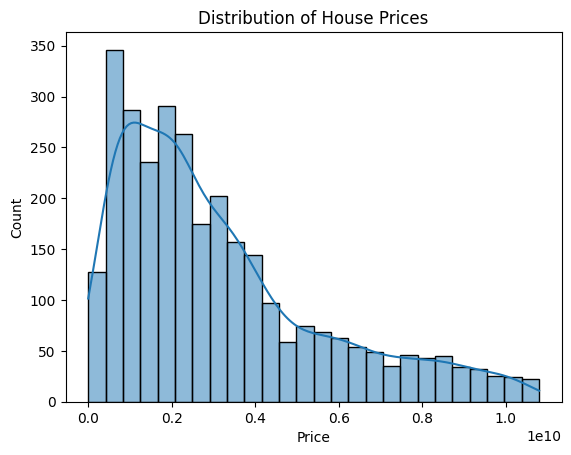

In [22]:
sns.histplot(clean_data['Price'], kde=True)
plt.title("Distribution of House Prices")
plt.show()

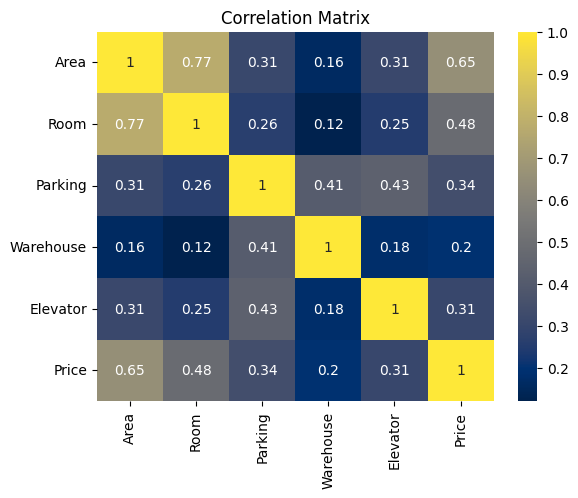

In [23]:
sns.heatmap(clean_data.corr(numeric_only=True), annot=True, cmap="cividis")
plt.title("Correlation Matrix")
plt.show()

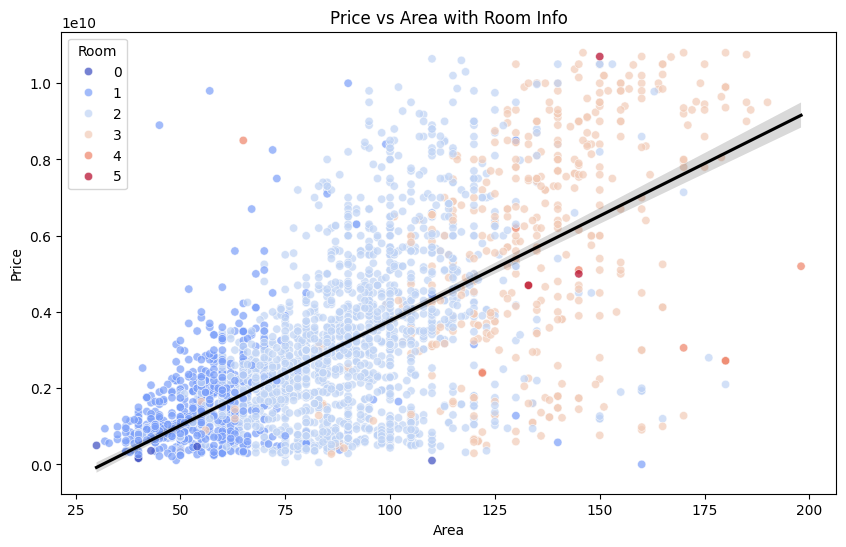

In [24]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Area', y='Price', hue='Room', palette='coolwarm', alpha=0.7, data=clean_data)
sns.regplot(x='Area', y='Price', data=clean_data, scatter=False, color='black')
plt.title("Price vs Area with Room Info")
plt.show()

<Figure size 1000x400 with 0 Axes>

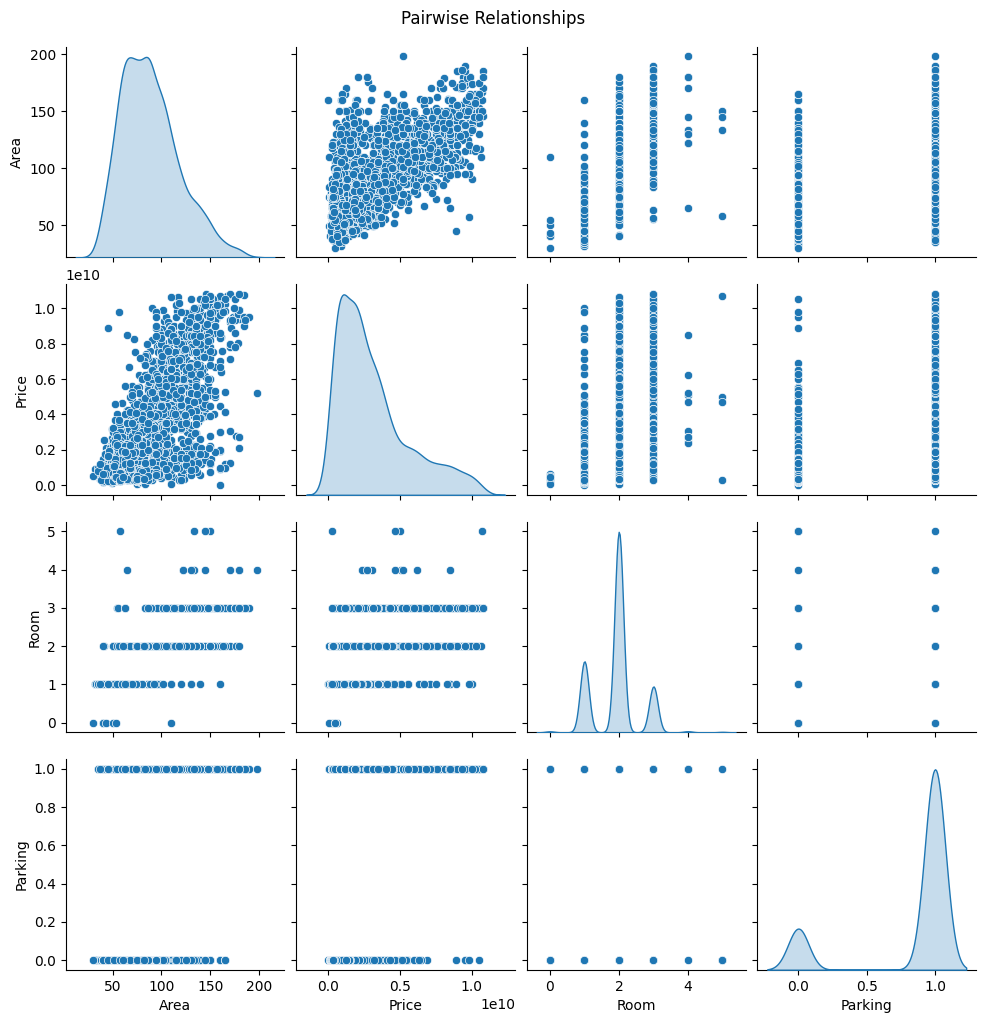

In [25]:
plt.figure(figsize=(10,4))
sns.pairplot(clean_data[['Area', 'Price', 'Room', 'Parking']], diag_kind="kde")
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()

In [26]:
df3 = clean_data['Address'].value_counts().copy()
df3 = df3[:8]

/tmp/ipykernel_50558/1489271037.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df3.values, y=df3.index,ax=ax,palette='viridis')


Text(0.5, 1.0, 'Number of flats in location')

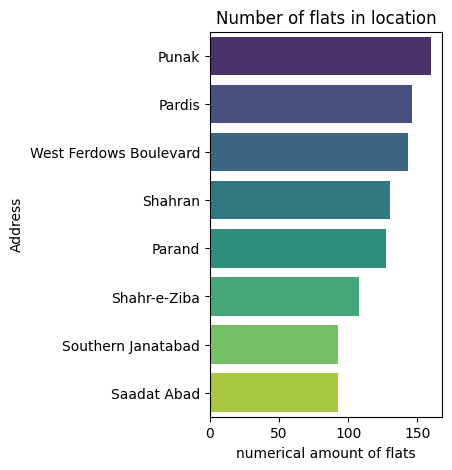

In [27]:
fig, ax = plt.subplots(figsize=(3,5))
sns.barplot(x=df3.values, y=df3.index,ax=ax,palette='viridis')
plt.xlabel('numerical amount of flats')
plt.title('Number of flats in location')

In [28]:
def create_model(df, model, parameters):
    start = time.time()  # Start timer for training duration
    X = df.drop(columns=["Price"])
    y = df["Price"]
    X_train,X_test,y_train , y_test = train_test_split(X , y , test_size=0.2,random_state=123)

    # Build pipeline: encoding categorical features, scaling, and applying the model
    pipeline = Pipeline(
        [
            ("encoder", ce.CatBoostEncoder(cols=["Address"])),
            ("scaler", StandardScaler()),
            ("model", model),
        ]
    )

    # Perform hyperparameter tuning with cross-validation
    grid = GridSearchCV(
        pipeline,
        parameters,
        cv=KFold(n_splits=5, shuffle=True, random_state=123),
        n_jobs=-1,
    )

    # Train the model
    grid_fit = grid.fit(X_train, y_train)

    # Make predictions
    y_train_pred = grid_fit.predict(X_train)
    y_pred = grid_fit.predict(X_test)

    # Evaluate performance
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MAE = mean_absolute_error(y_test, y_pred)

    model_name = str(model).split("(")[0]  # Get model name
    end = time.time()  # End timer

    # Print evaluation results
    print(f"The best parameters for {model_name} model is: {grid_fit.best_params_}")
    print("--" * 10)
    print(f"(R2 score) in the training set is {r2_train:0.2%} for {model_name} model.")
    print(f"(R2 score) in the testing set is {r2_test:0.2%} for {model_name} model.")
    print(f"RMSE is {int(RMSE):,} for {model_name} model.")
    print(f"MAE is {int(MAE):,} for {model_name} model.")
    print("--" * 20)
    print(f"Runtime of the program is: {end - start:0.3f} seconds")

    return r2_train, r2_test, RMSE , MAE


### Decision Tree

In [ ]:
dtr = DecisionTreeRegressor(random_state=123)
dtr_param = {
        "model__criterion": ["squared_error", "absolute_error"],
        "model__max_features": ["sqrt", "log2"],
        "model__max_depth": [4, 5, 6],
        "model__min_samples_split": [3, 5, 7],
        "model__min_samples_leaf": [2, 3]
}
dt_r2_train, dt_r2_test, dt_RMSE , dt_MAE = create_model(clean_data , dtr , dtr_param)

The best parameters for DecisionTreeRegressor model is: {'model__criterion': 'squared_error', 'model__max_depth': 6, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}
--------------------
(R2 score) in the training set is 83.35% for DecisionTreeRegressor model.
(R2 score) in the testing set is 78.56% for DecisionTreeRegressor model.
RMSE is 1,172,796,570 for DecisionTreeRegressor model.
MAE is 738,901,760 for DecisionTreeRegressor model.
----------------------------------------
Runtime of the program is: 5.695 seconds


### Random Forest

In [31]:
rfr = RandomForestRegressor(random_state=123)
rfr_param = {
        "model__n_estimators": [50, 100, 150],
        "model__max_depth": [4, 6, 8],
        "model__min_samples_split": [3, 5, 7],
        "model__min_samples_leaf": [2, 3]
    }

rf_r2_train, rf_r2_test, rf_RMSE , rf_MAE = create_model(clean_data , rfr , rfr_param)

The best parameters for RandomForestRegressor model is: {'model__max_depth': 8, 'model__min_samples_leaf': 2, 'model__min_samples_split': 7, 'model__n_estimators': 150}
--------------------
(R2 score) in the training set is 88.78% for RandomForestRegressor model.
(R2 score) in the testing set is 82.48% for RandomForestRegressor model.
RMSE is 1,060,303,936 for RandomForestRegressor model.
MAE is 634,092,430 for RandomForestRegressor model.
----------------------------------------
Runtime of the program is: 18.803 seconds


### XGBoost

In [32]:
xgb = XGBRegressor(random_state=123)
xgb_param = {
        "model__n_estimators": [300, 500],
        "model__learning_rate": [0.01, 0.05],
        "model__max_depth": [3, 5],
        "model__min_child_weight": [3, 5],
        "model__subsample": [0.8],
        "model__colsample_bytree": [0.8],
        "model__gamma": [0, 0.2],
        "model__reg_alpha": [0.1],
        "model__reg_lambda": [1, 2]
    }
xgb_r2_train, xgb_r2_test, xgb_RMSE ,xgb_MAE =create_model(clean_data , xgb , xgb_param)

The best parameters for XGBRegressor model is: {'model__colsample_bytree': 0.8, 'model__gamma': 0, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 3, 'model__n_estimators': 500, 'model__reg_alpha': 0.1, 'model__reg_lambda': 1, 'model__subsample': 0.8}
--------------------
(R2 score) in the training set is 88.78% for XGBRegressor model.
(R2 score) in the testing set is 83.43% for XGBRegressor model.
RMSE is 1,030,961,893 for XGBRegressor model.
MAE is 622,108,130 for XGBRegressor model.
----------------------------------------
Runtime of the program is: 14.733 seconds


### ElasticNet

In [33]:
eln = ElasticNet(random_state=1)
eln_param = {
        "model__alpha": [0.01, 0.1, 0.5, 1, 5, 10],
        "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
        }
eln_r2_train, eln_r2_test, eln_RMSE , eln_MAE=create_model(clean_data , eln , eln_param)

The best parameters for ElasticNet model is: {'model__alpha': 0.1, 'model__l1_ratio': 0.7}
--------------------
(R2 score) in the training set is 82.68% for ElasticNet model.
(R2 score) in the testing set is 80.36% for ElasticNet model.
RMSE is 1,122,654,208 for ElasticNet model.
MAE is 776,652,948 for ElasticNet model.
----------------------------------------
Runtime of the program is: 0.669 seconds


In [40]:
models_score = pd.DataFrame({'Training': [eln_r2_train*100, dt_r2_train*100 , rf_r2_train*100,xgb_r2_train*100],
                             'Testing': [eln_r2_test*100 ,dt_r2_test*100, rf_r2_test*100,xgb_r2_test*100],
                             'RMSE': [eln_RMSE, dt_RMSE, rf_RMSE , xgb_RMSE],
                             "MAE":[eln_MAE ,dt_MAE,rf_MAE,xgb_MAE ]},
                             index = ['ElasticNet', 'DecisionTreeRegressor', 'RandomForestRegressor','XGBoostRegressor'])

models_score

,Training,Testing,RMSE,MAE
ElasticNet,83,80,"1,122,654,208","776,652,949"
DecisionTreeRegressor,83,79,"1,172,796,570","738,901,760"
RandomForestRegressor,89,82,"1,060,303,937","634,092,430"
XGBoostRegressor,89,83,"1,030,961,893","622,108,130"
